In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

In [6]:
data_path = 'C:/onlab_git/Onlab/data_with_centers/'
train_percent = 0.614
test_percent = 0.30


files = os.listdir(data_path)
train_size = int(train_percent * len(files))
val_size = len(files) - train_size
if test_percent>0:
    test_size = int(test_percent * len(files))
    val_size = val_size - test_size

print('Train size:', train_size)
print('Validation size:', val_size)
print('Test size:', test_size)

Train size: 100
Validation size: 15
Test size: 48


In [25]:
wrong_masks = ['33.npz', '38.npz', '56.npz', '58.npz', '59.npz', '68.npz', '78.npz', '99.npz', '100.npz', '103.npz', '106.npz', 
            '108.npz', '109.npz', '110.npz', '112.npz', '113.npz', '117.npz', '119.npz', '121.npz', '123.npz', '130.npz', '131.npz', '143.npz']


basic_padding_fix = ['33.npz', '38.npz',  '58.npz', '59.npz',  '78.npz', '119.npz', '121.npz', '123.npz']
top_padding_fix = ['99.npz', '100.npz', '110.npz', '113.npz', '143.npz']
hard_padding_fix = [ '103.npz', '106.npz', '108.npz', '109.npz', '112.npz']

In [37]:
padded_masks = ['33.npz', '38.npz', '59.npz', '78.npz', '99.npz', '100.npz', '103.npz', '106.npz', '108.npz', '109.npz', '110.npz', '112.npz', '113.npz', 
'117.npz', '119.npz', '121.npz', '123.npz', '143.npz']
still_not_fixed = ['59.npz', '103.npz', '106.npz', '108.npz', '112.npz', '113.npz', '119.npz', '121.npz']


cell_count_issue = ['56.npz','68.npz', "102.npz", "129.npz", '130.npz', '131.npz']
biosensor_cut_extra_cells_on_mask = ["0.npz", "1.npz", "2.npz", "4.npz", "5.npz", "6.npz", "9.npz", "11.npz", "15.npz", "16.npz", "17.npz", "18.npz", "19.npz", 
"20.npz", "21.npz", "22.npz", "23.npz", "24.npz", "25.npz", "26.npz", "27.npz", "28.npz", "29.npz", "31.npz", "34.npz", "35.npz", "37.npz", "39.npz", 
"40.npz", "43.npz", "44.npz", "47.npz", "48.npz", "49.npz", "75.npz", "79.npz", "83.npz", "85.npz", "89.npz", "90.npz", "94.npz", "98.npz", "104.npz", "105.npz", "108.npz", 
"122.npz", "123.npz", "137.npz", "141.npz", "146.npz", "149.npz", "152.npz", "158.npz", "159.npz", "160.npz"]

In [ ]:
for file in biosensor_cut_extra_cells_on_mask:
    data = np.load(data_path + file)

    bio = data['biosensor'].astype(np.float32)
    name = data['old_filename']
    mask = torch.from_numpy(data['mask'].astype(bool))

    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 4, 1)
    plt.imshow(bio[-1], cmap='gray')
    plt.title(name)

    plt.subplot(1, 4, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(file)

    plt.subplot(1, 4, 3)
    plt.imshow(bio[-1], cmap='gray')
    plt.imshow(scale_mask(mask, 80), cmap='Reds', alpha=0.25)
    plt.show()

In [ ]:
for file in biosensor_cut_extra_cells_on_mask:
    data = np.load(data_path + file)

    bio = data['biosensor'].astype(np.float32)
    name = data['old_filename']
    mask = torch.from_numpy(data['mask'].astype(np.uint8))

    print(name)

In [ ]:
# NEED TO RECALCULATE CELL CENTERS FOR CHANGED MASKS

In [11]:
def plot_alignment(bio, mask, padded_mask, name, file):
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 4, 1)
    plt.imshow(bio, cmap='gray')
    plt.title(name)

    plt.subplot(1, 4, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(file)

    plt.subplot(1, 4, 3)
    plt.imshow(padded_mask, cmap='gray')
    plt.title('Padded mask')

    plt.subplot(1, 4, 4)
    plt.imshow(bio, cmap='gray')
    plt.imshow(scale_mask(padded_mask, 80), cmap='Reds', alpha=0.25)
    plt.show()

def plot_alignment_centers(bio, mask, padded_mask, name, file, centers):
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 4, 1)
    plt.imshow(bio, cmap='gray')
    plt.title(name)

    plt.subplot(1, 4, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(file)

    plt.subplot(1, 4, 3)
    plt.imshow(padded_mask, cmap='gray')
    plt.title('Padded mask')

    plt.subplot(1, 4, 4)
    plt.imshow(bio, cmap='gray')
    plt.imshow(scale_mask_with_centers(padded_mask, centers, 80), cmap='Reds', alpha=0.25)
    plt.show()
    
def basic_mask_padding(mask):
    X = mask.shape[0]
    Y = mask.shape[1]
    # Calculate padding
    if X > Y:
        padding = (0, X - Y, 0, 0)
    else:
        padding = (0, 0, 0, Y - X)
    return torch.nn.functional.pad(mask, padding, mode='constant', value=0)

def top_padding(mask):
    X = mask.shape[0]
    Y = mask.shape[1]
    # Calculate padding
    if Y > X:
        padding = (0, 0, Y - X, 0)
    else:
        padding = (0, 0, 0, 0)
    return torch.nn.functional.pad(mask, padding, mode='constant', value=0)

def scale_mask(mask, mask_size):
    interpolated_mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=(mask_size, mask_size), mode='nearest').squeeze(0).squeeze(0).byte()

    return interpolated_mask.cpu().numpy()

def scale_mask_with_centers(mask, centers, mask_size):
    interpolated_mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=(mask_size, mask_size), mode='nearest').squeeze(0).squeeze(0).byte()

    x_scale = mask.shape[0] / mask_size
    y_scale = mask.shape[1] / mask_size
    
    scaled_centers = centers / [x_scale, y_scale]

    indices = np.transpose(scaled_centers.astype(int))
    interpolated_mask[indices[0], indices[1]] = True

    return interpolated_mask.cpu().numpy()

def save_padded_mask(data_path, file, padded_mask, data):
    mask = padded_mask.cpu().numpy()

    cell_numbers = np.unique(mask)[1:]
    # Calculate average row and column indices for each cell number
    avg_indices = [np.mean(np.argwhere(mask == cell_num), axis=0) for cell_num in cell_numbers]
    # Convert to list of tuples
    cell_centers = [tuple(indices) for indices in avg_indices]

    new_data = {'old_filename': data['old_filename'], 'biosensor': data['biosensor'], 'mask': mask, 'cell_centers': cell_centers}

    np.savez(data_path + file, **new_data)
    # return new_data


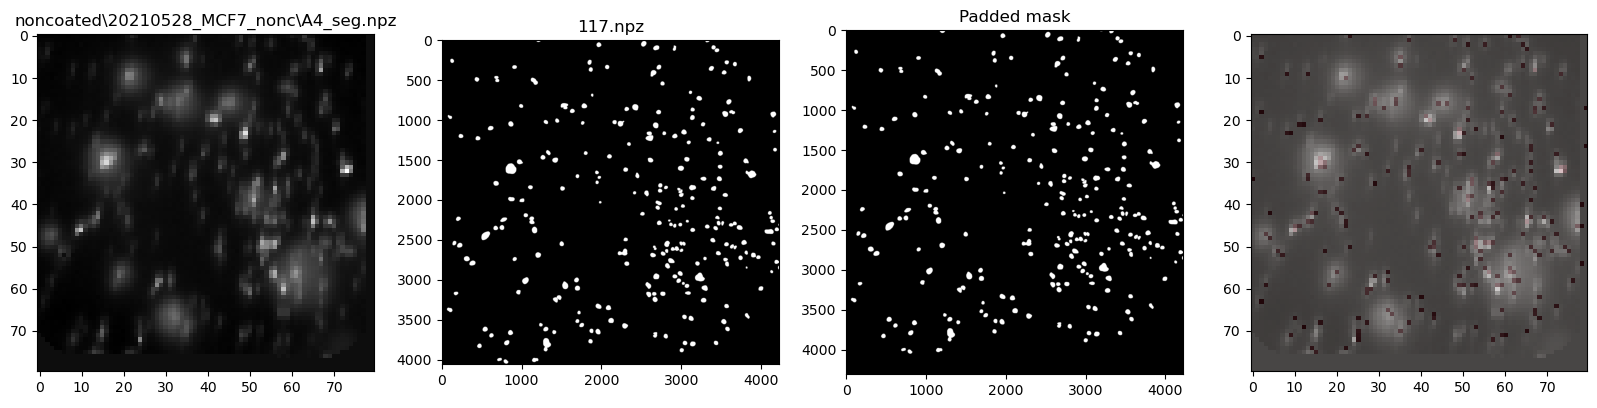

In [9]:
data = np.load(data_path + '117.npz')

bio = data['biosensor'].astype(np.float32)
name = data['old_filename']
mask = torch.from_numpy(data['mask'].astype(bool))

padding = (0, 0, 0, 250)
padded_mask = torch.nn.functional.pad(mask, padding, mode='constant', value=0)

plot_alignment(bio[-1], mask, padded_mask, name, '117.npz')
# plot_alignment_centers(bio[-1], mask, padded_mask, name, '117.npz', data['cell_centers'])
# save_padded_mask(data_path, '117.npz', padded_mask, data)

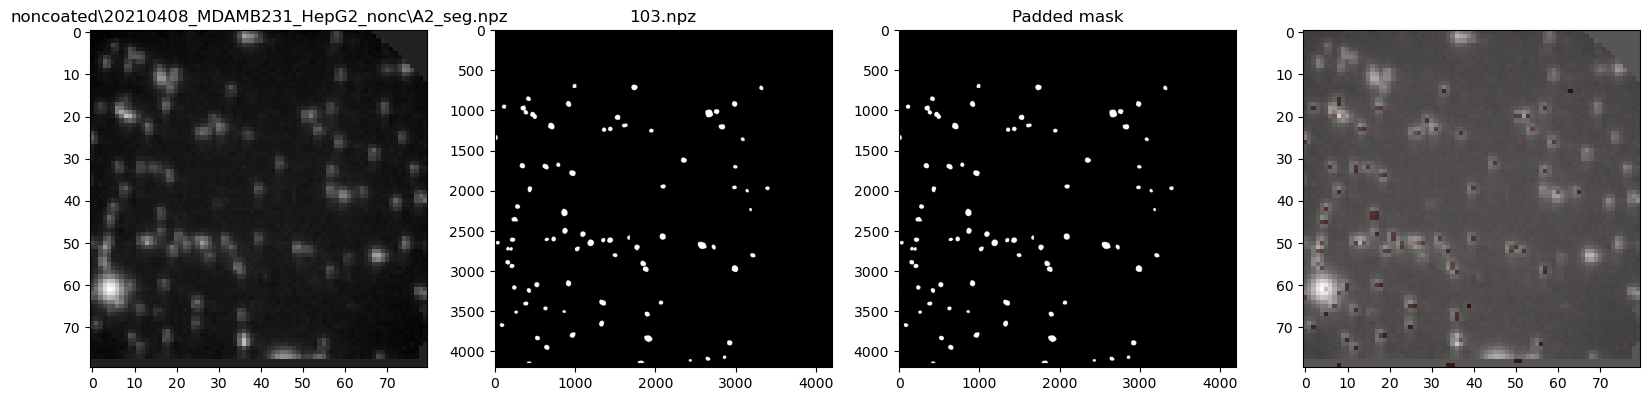

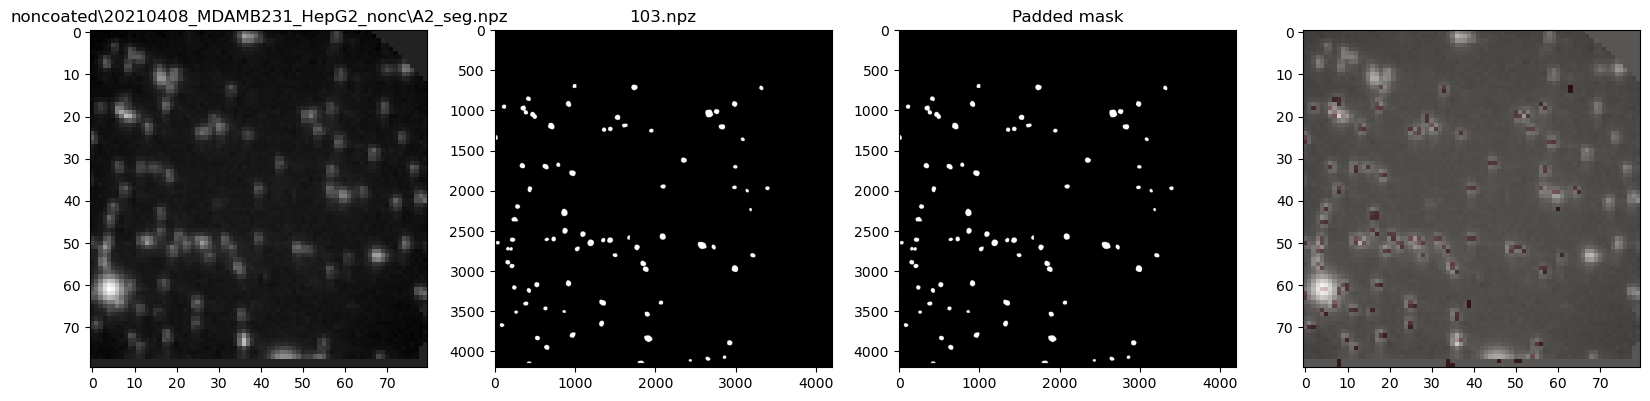

84


In [105]:
data = np.load(data_path + hard_padding_fix[0])

bio = data['biosensor'].astype(np.float32)
name = data['old_filename']
mask = torch.from_numpy(data['mask'].astype(bool))

# padding = (0, 700, 550, 50)
# padded_mask = torch.nn.functional.pad(mask, padding, mode='constant', value=0)

# plot_alignment(bio[-1], mask, mask, name, hard_padding_fix[0])
plot_alignment_centers(bio[-1], mask, mask, name, hard_padding_fix[0], data['cell_centers'])


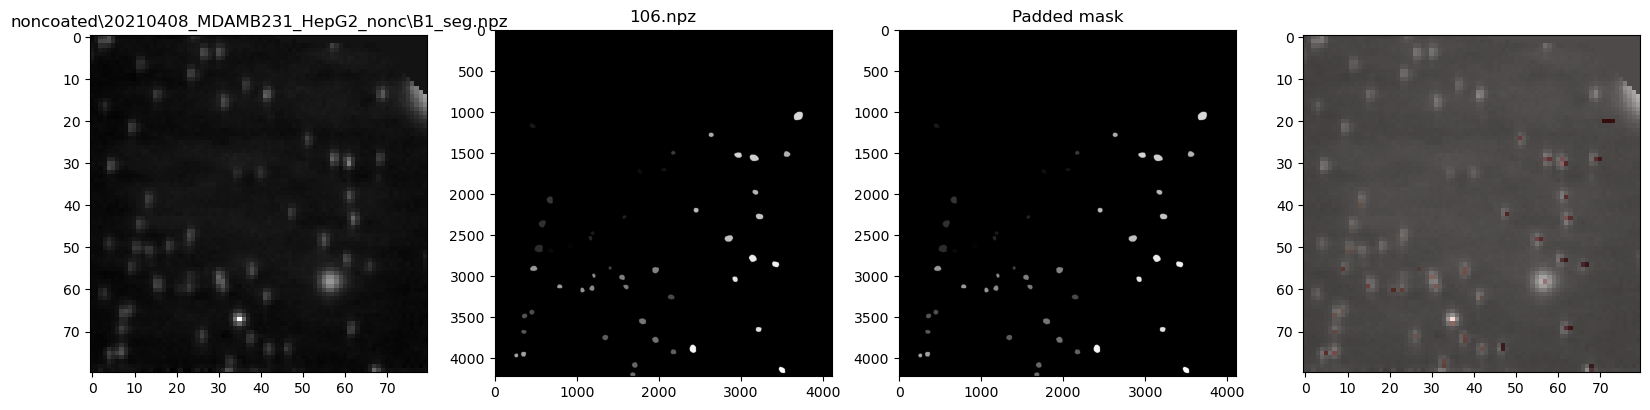

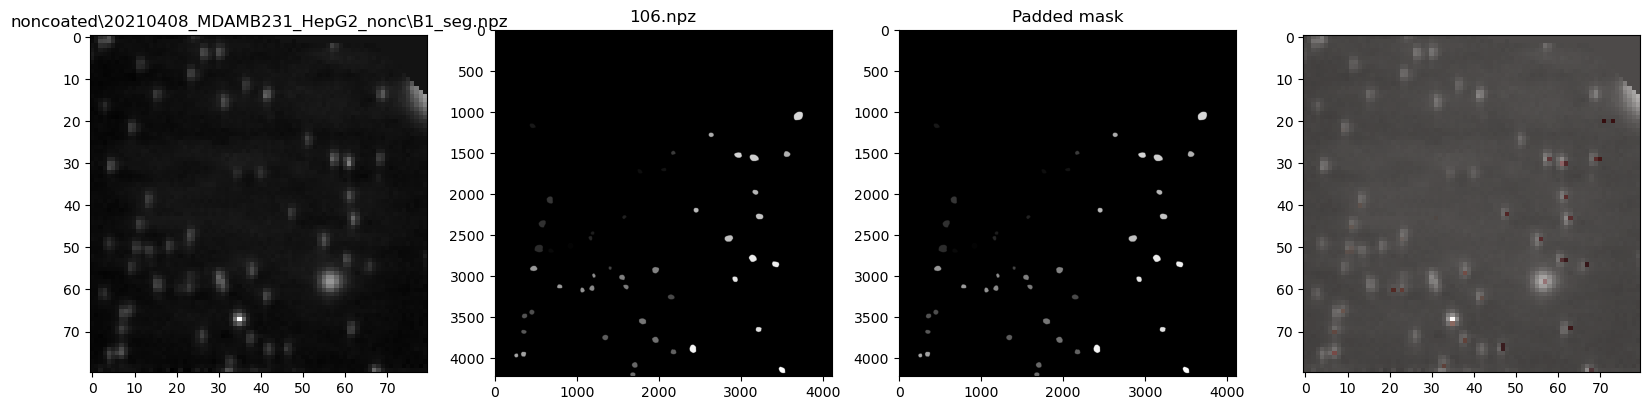

In [111]:
data = np.load(data_path + hard_padding_fix[1])

bio = data['biosensor'].astype(np.float32)
name = data['old_filename']
mask = torch.from_numpy(data['mask'].astype(np.uint8))

# padding = (200, 0, 900, 0)
# padded_mask = torch.nn.functional.pad(mask, padding, mode='constant', value=0)

# plot_alignment(bio[-1], mask, mask, name, hard_padding_fix[1])
plot_alignment_centers(bio[-1], mask, mask, name, hard_padding_fix[1], data['cell_centers'])

# save_padded_mask(data_path, hard_padding_fix[1], padded_mask, data)

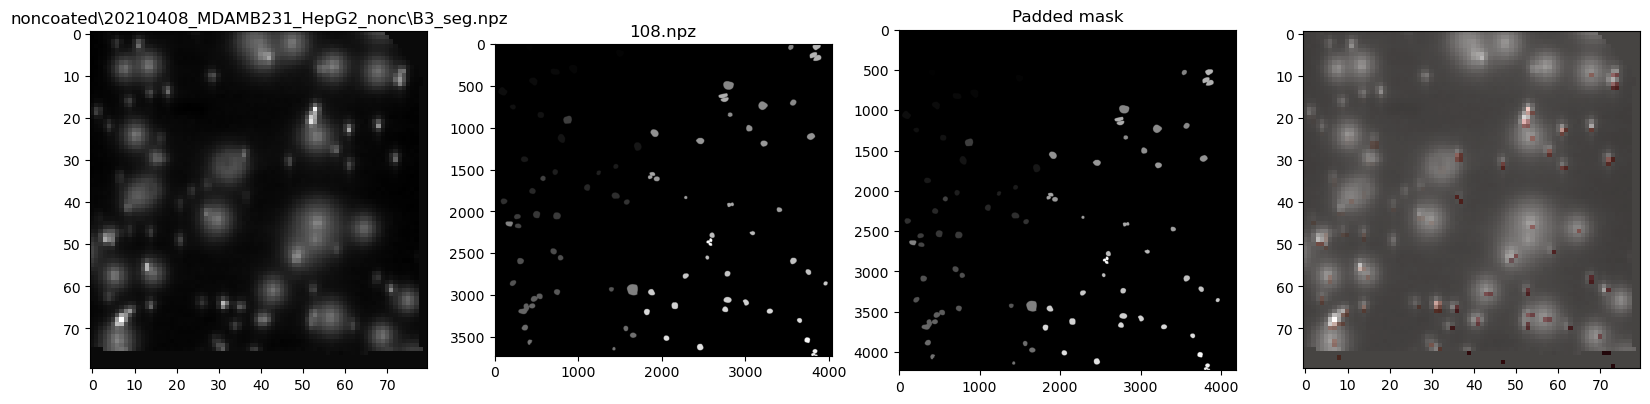

In [114]:
data = np.load(data_path + hard_padding_fix[2])

bio = data['biosensor'].astype(np.float32)
name = data['old_filename']
mask = torch.from_numpy(data['mask'].astype(np.uint8))

padding = (0, 150, 500, 0)
padded_mask = torch.nn.functional.pad(mask, padding, mode='constant', value=0)

plot_alignment(bio[-1], mask, padded_mask, name, hard_padding_fix[2])

# save_padded_mask(data_path, hard_padding_fix[2], padded_mask, data)

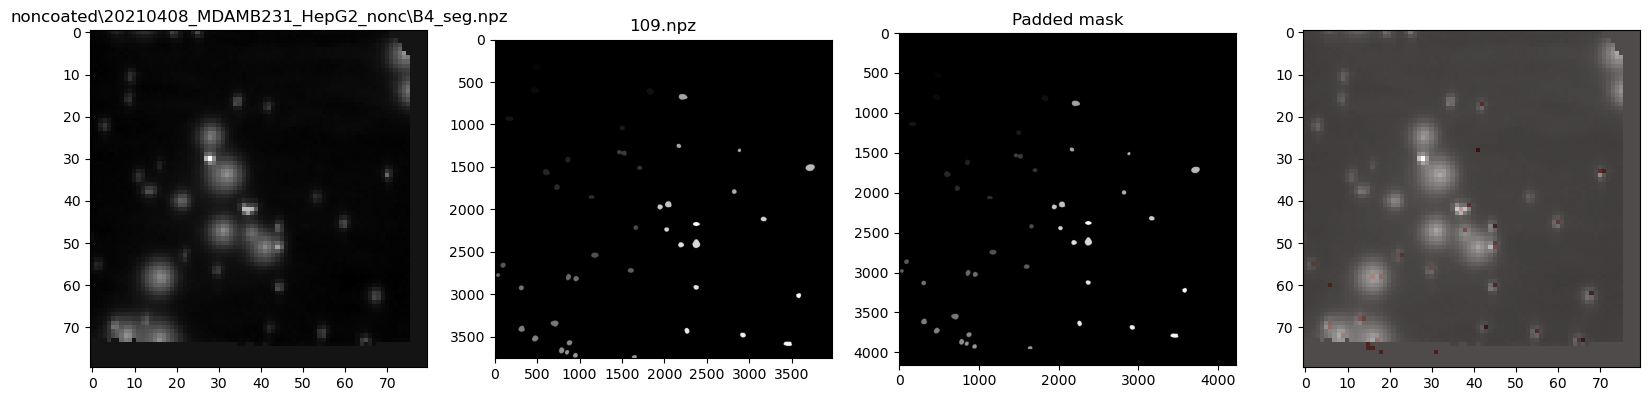

In [118]:
data = np.load(data_path + hard_padding_fix[3])

bio = data['biosensor'].astype(np.float32)
name = data['old_filename']
mask = torch.from_numpy(data['mask'].astype(np.uint8))

padding = (0, 250, 200, 200)
padded_mask = torch.nn.functional.pad(mask, padding, mode='constant', value=0)

plot_alignment(bio[-1], mask, padded_mask, name, hard_padding_fix[3])

# save_padded_mask(data_path, hard_padding_fix[3], padded_mask, data)

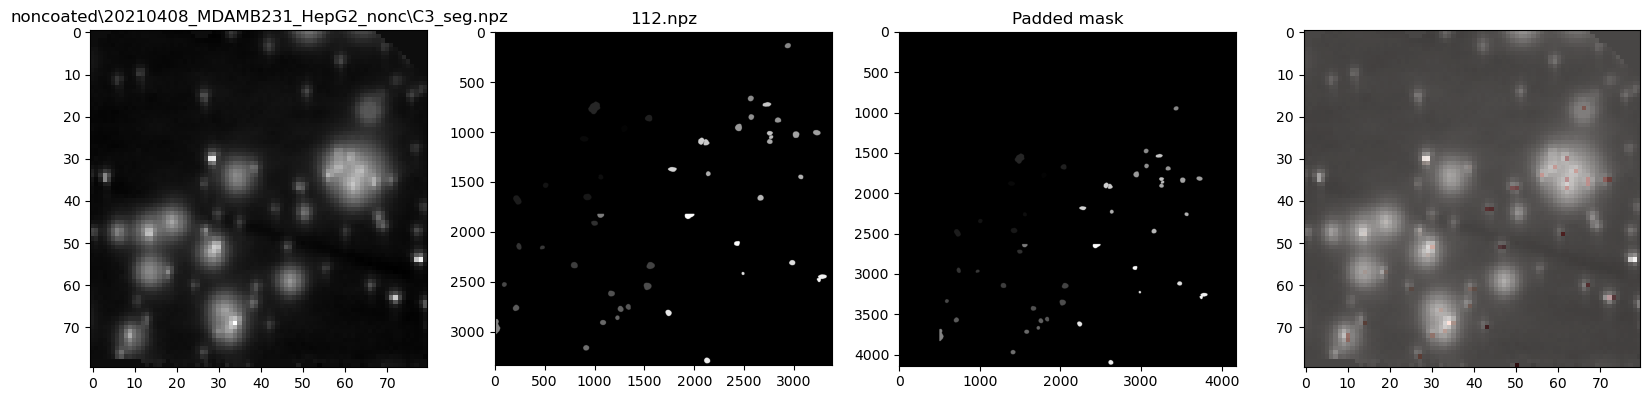

In [122]:
data = np.load(data_path + hard_padding_fix[4])

bio = data['biosensor'].astype(np.float32)
name = data['old_filename']
mask = torch.from_numpy(data['mask'].astype(np.uint8))

padding = (500, 300, 800, 0)
padded_mask = torch.nn.functional.pad(mask, padding, mode='constant', value=0)

plot_alignment(bio[-1], mask, padded_mask, name, hard_padding_fix[4])

# save_padded_mask(data_path, hard_padding_fix[4], padded_mask, data)

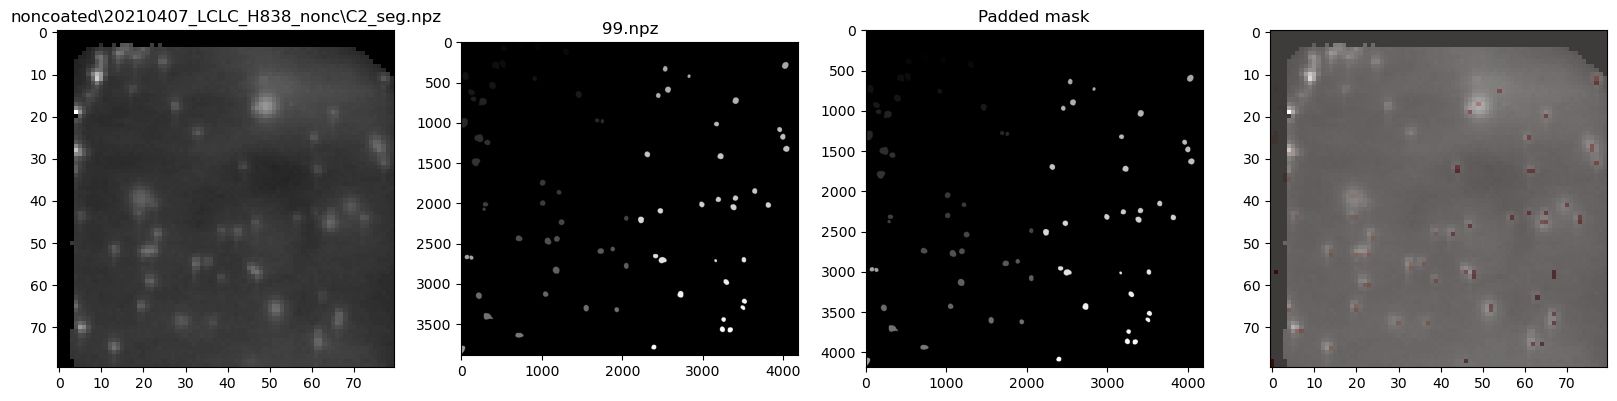

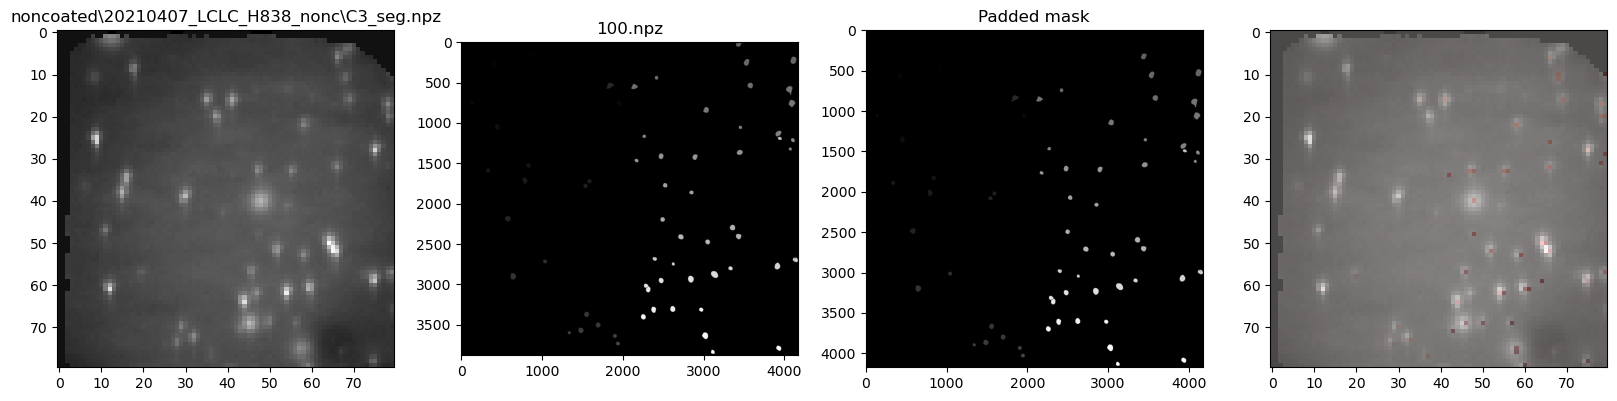

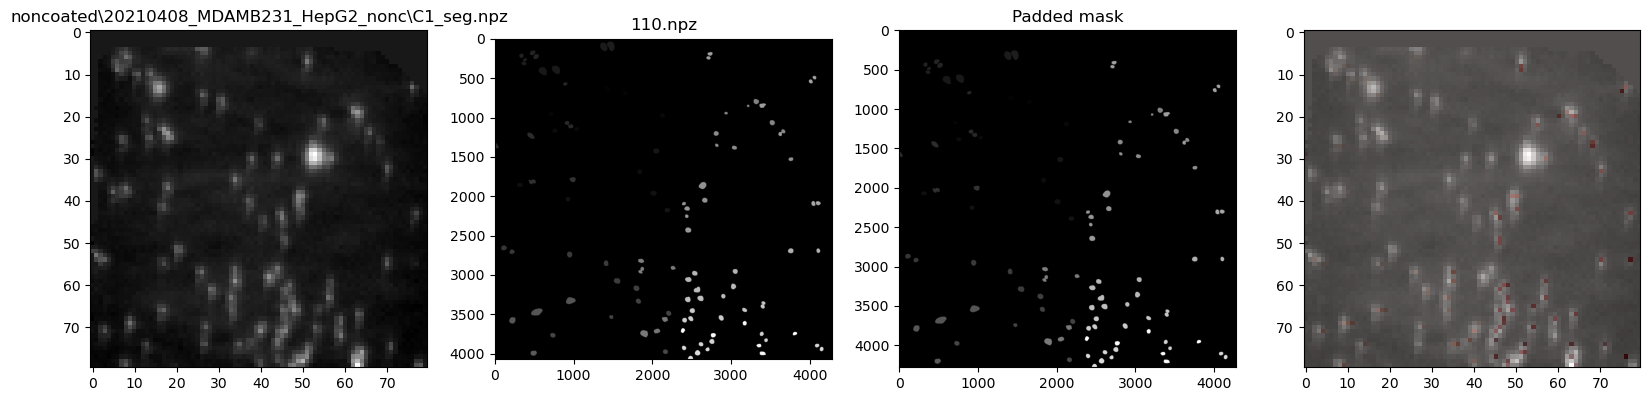

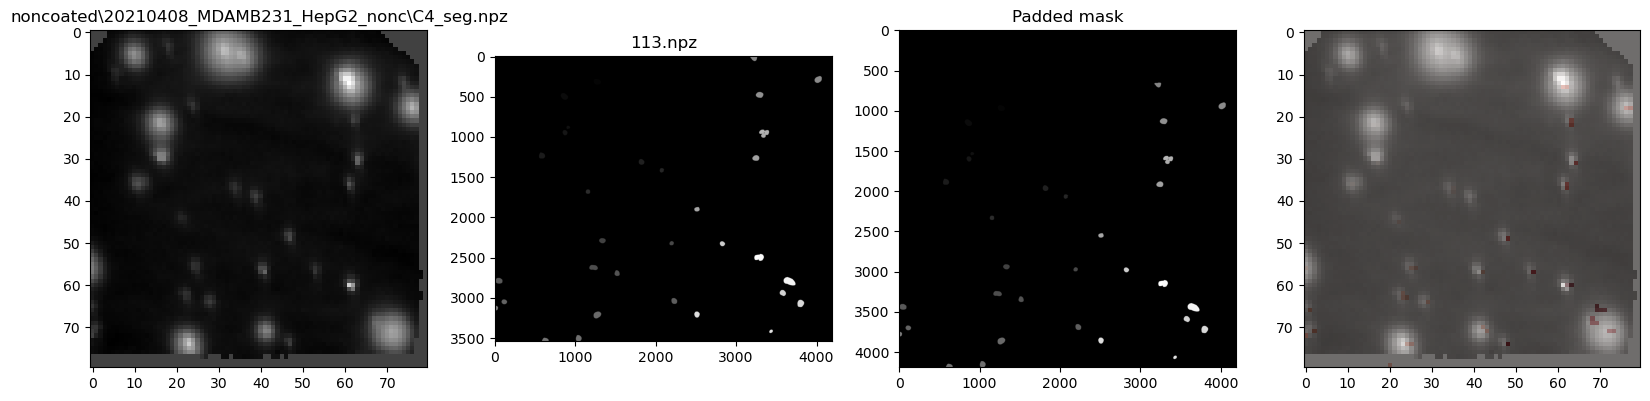

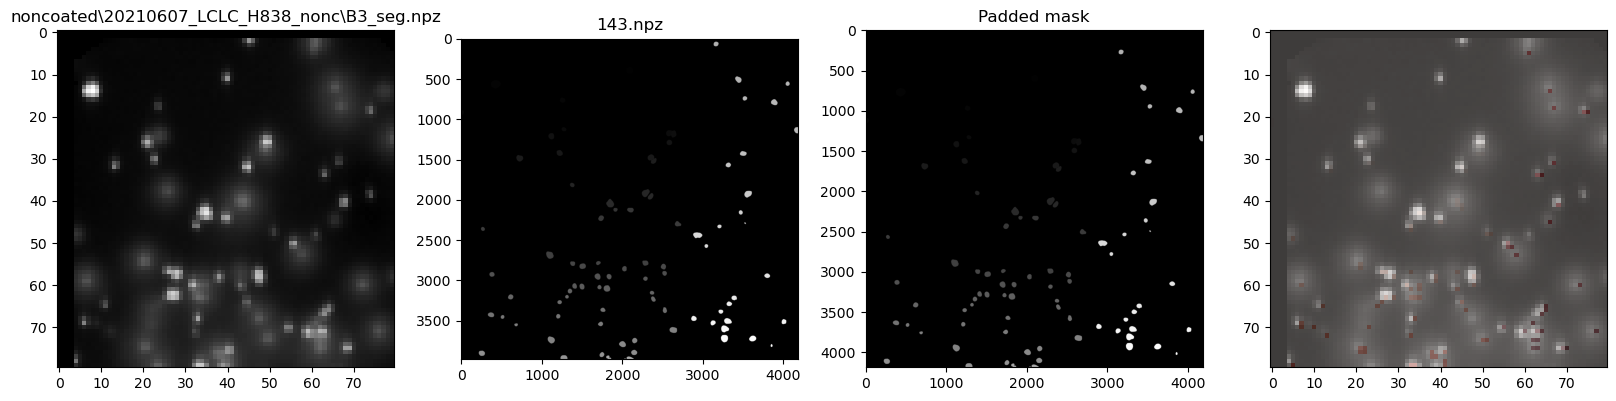

In [125]:
for file in top_padding_fix:
    # these ones need special padding to align the mask with the biosensor
    data = np.load(data_path + file)

    bio = data['biosensor'].astype(np.float32)
    name = data['old_filename']
    mask = torch.from_numpy(data['mask'].astype(np.uint8))

    plot_alignment(bio[-1], mask, top_padding(mask), name, file)

    # save_padded_mask(data_path, file, top_padding(mask), data)

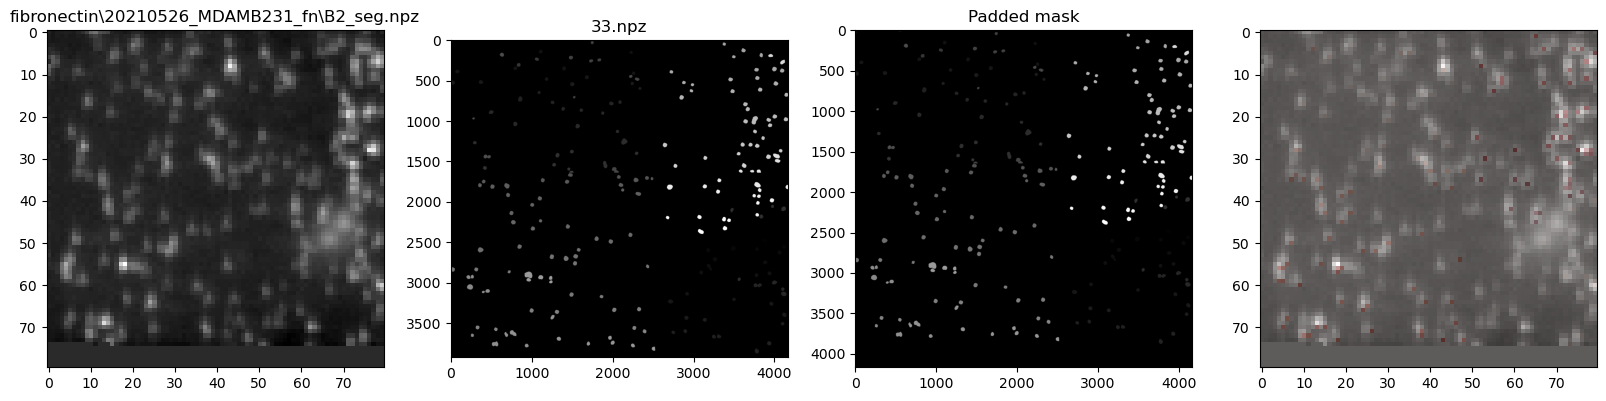

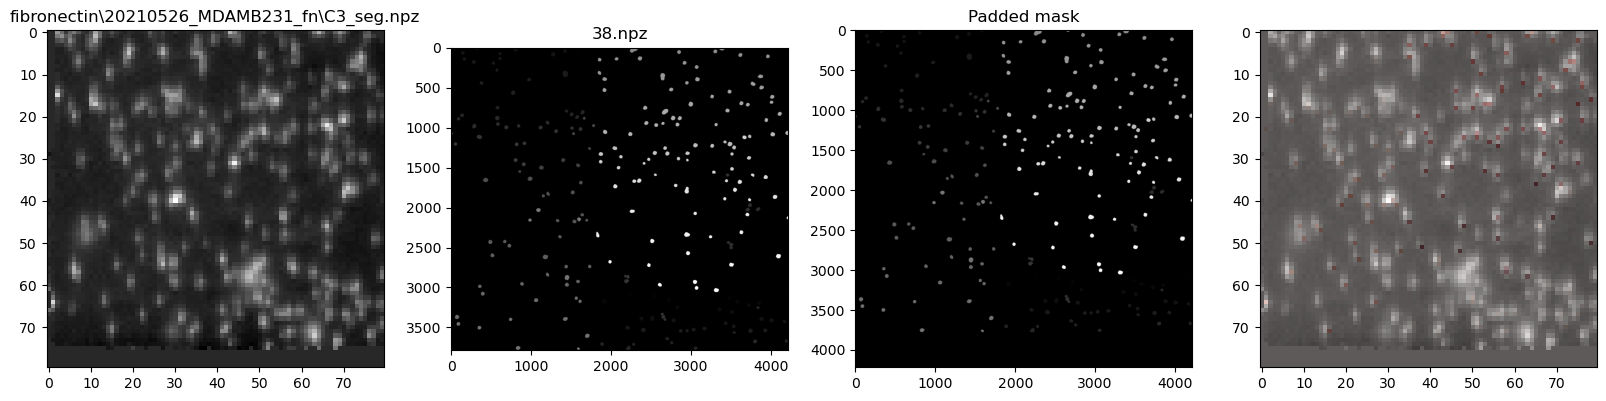

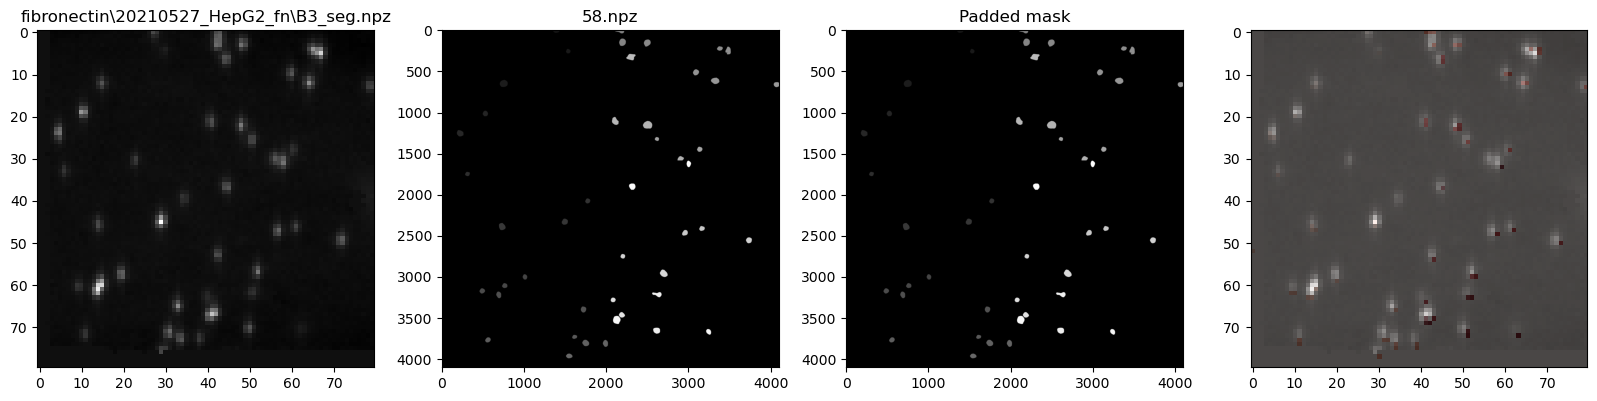

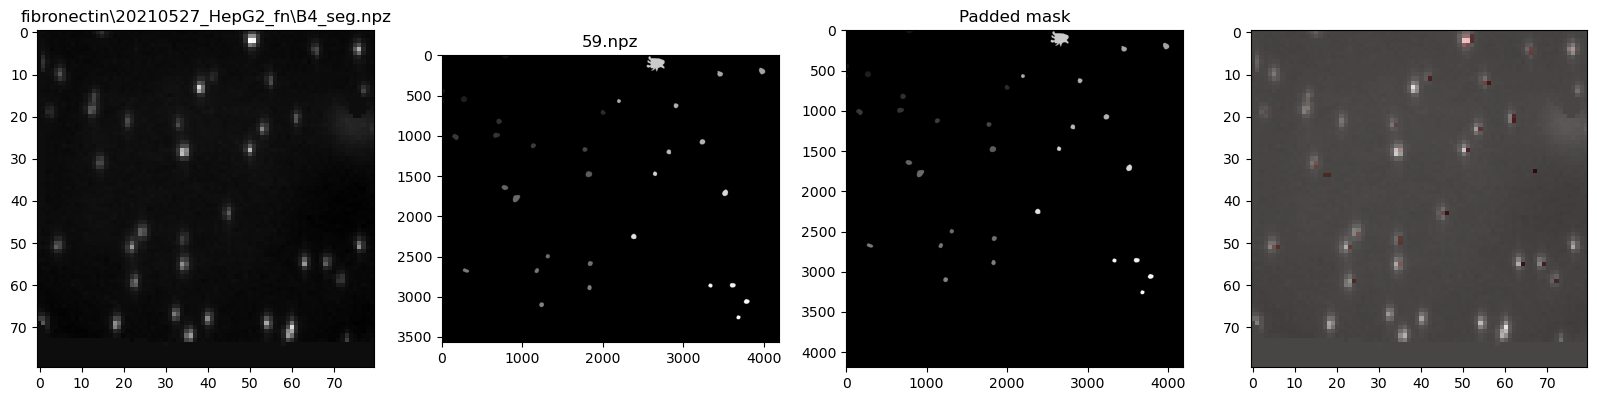

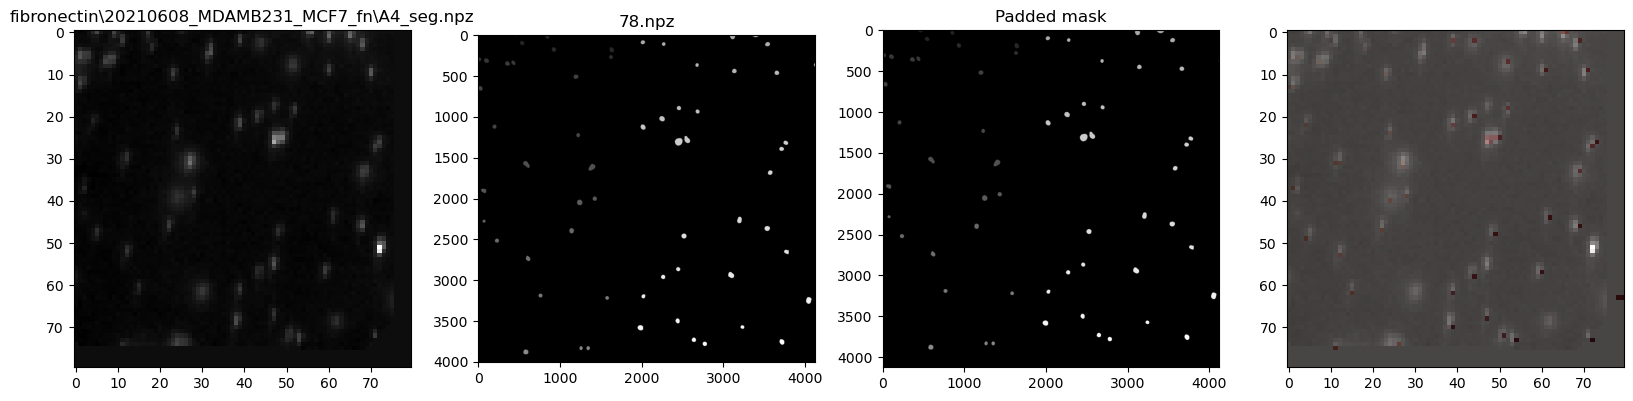

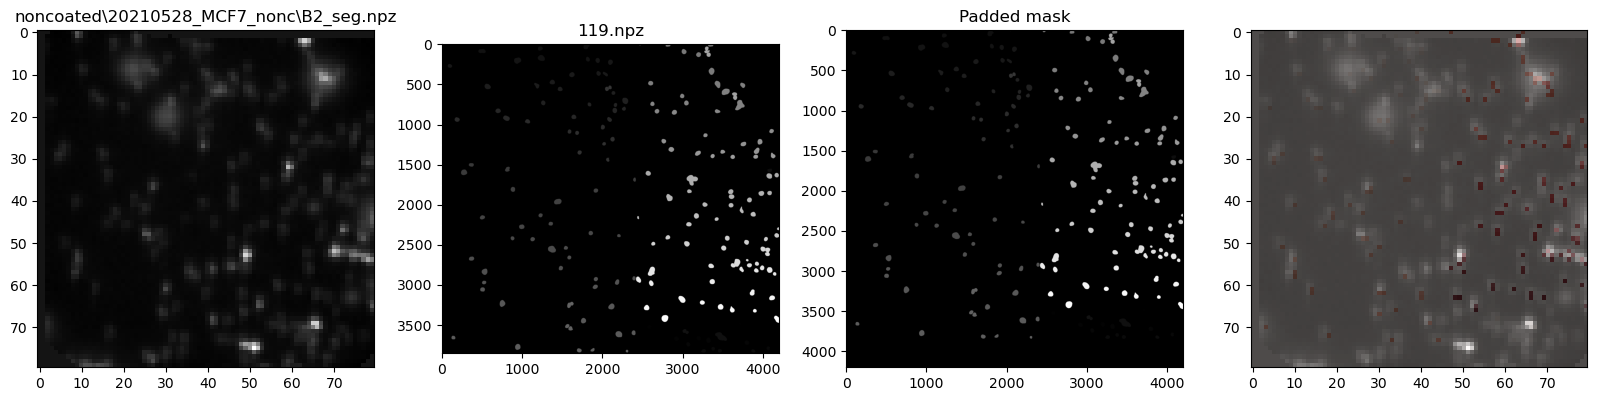

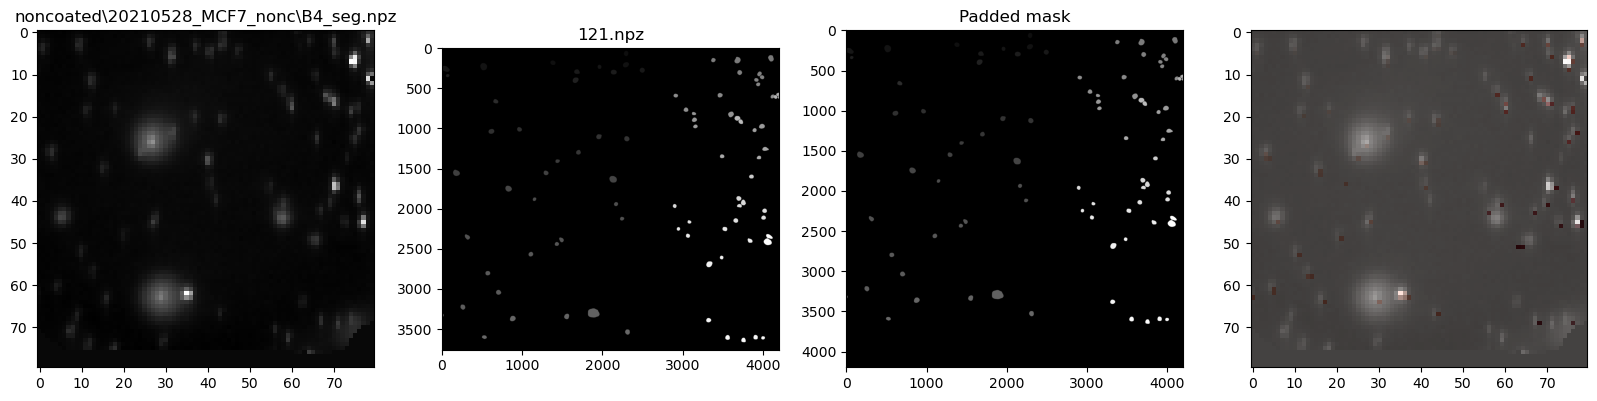

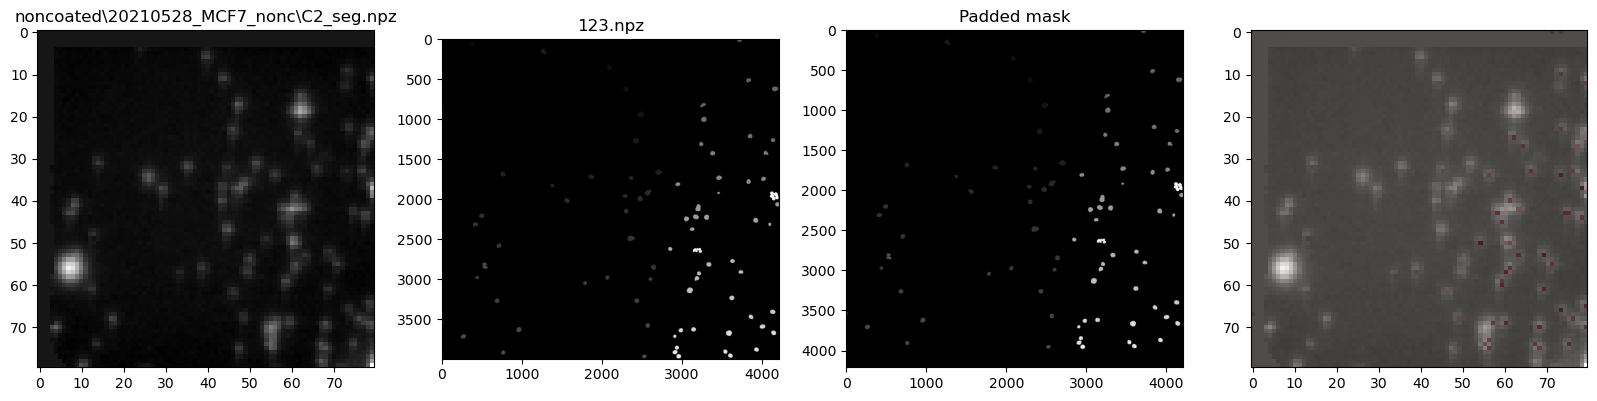

In [127]:
for file in basic_padding_fix:
    data = np.load(data_path + file)

    bio = data['biosensor'].astype(np.float32)
    name = data['old_filename']
    mask = torch.from_numpy(data['mask'].astype(np.uint8))

    plot_alignment(bio[-1], mask, basic_mask_padding(mask), name, file)

    # save_padded_mask(data_path, file, basic_mask_padding(mask), data)